In [2]:
import numpy as np
import pandas as pd

In [372]:
# data loading

data_train = pd.read_csv("spambase.train", header=None)
data_test = pd.read_csv("spambase.test", header=None)

def spamdata(data):
    """returns a tuple (target value, feature values)"""
    D = np.asarray(data, dtype=float)
    return np.asarray(D[:,-1], dtype=int), np.asarray(D[:,:-1])

t_train, X_train_raw = spamdata(data_train)
t_test, X_test_raw = spamdata(data_test)


In [439]:
# pre-processing
def preprocess_median(X, median = None):
    """
    If median is None, compute the median and return tuple
    """
    if median is None:
        median = np.median(X, axis=0)
        return np.asarray(X > median, dtype=int), median
    else:
        return np.asarray(X > median, dtype=int)


# _, medians = preprocess_median(np.concatenate((X_train_raw, X_test_raw)))
# X_train = preprocess_median(X_train_raw, medians)
# X_test = preprocess_median(X_test_raw, medians)

X_train, medians = preprocess_median(X_train_raw)
X_test = preprocess_median(X_test_raw, medians)

In [440]:
# dimension constants
M = 2 #our pre-processing fixes every feature to be either 0 or 1.
C = 2
D = X_train.shape[1]
print(C,D,M)

2 57 2


In [441]:
def train_NB(X, t, C, D, M, alpha = None, beta = None):
    """
    Alpha and beta are Dirichlet prior parameters for *mean* estimate.
    """
    N = t.size
    if alpha is None:
        alpha = np.zeros(C)
    if beta is None:
        beta = np.zeros(shape=(C,D,M))
    pi = np.zeros(shape=(C))
    theta = np.zeros(shape=(C,D,M))
    
    alpha_sum = np.sum(alpha)
    N = t.size
    for c in range(C):
        indices = t == c
        Nc = np.count_nonzero(indices)
        pi[c] = (Nc + alpha[c]) / (N + alpha_sum)
        for d in range(D):            
            counts = np.bincount(X[indices, d], minlength = M)
            theta[c,d,:] = (counts + beta[c,d,:]) / (Nc + np.sum(beta[c,d,:]))
    return pi, theta

# compute the MLE (equivalent to mean estimate with Dirichlet prior parameters all equal to 0)
pi0, theta0 = train_NB(X_train, t_train, C, D, M)

"""it's enough to print m=0 params only, because theta[:,:,1] = 1 - theta[:,:,0]"""
# print (pi0, theta0[:,:,0]) 

"it's enough to print m=0 params only, because theta[:,:,1] = 1 - theta[:,:,0]"

In [442]:
def pred_NB(X, pi, theta, returnRatio = False):
    """
    make predictions by comparing the probabilities in the log space.
    """
    D = theta.shape[1]
    probs = np.sum(np.log(theta[:,np.arange(D),X]), axis=2).T + np.log(pi)
    if returnRatio:
        return np.argmax(probs ,axis=1), probs
    else:
        return np.argmax(probs ,axis=1)
def test_NB(X, t, pi, theta):
    """
    returns the error rates
    """
    t_pred = pred_NB(X, pi, theta)
    return np.sum(t != t_pred) / t.size

print(test_NB(X_test,t_test, pi0, theta0))

0.108035371011


In [504]:
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, (bins,2))[0]
    print(c_xy.shape)
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mutual_info = np.asarray([mutual_info_score(t_train,X_train[:,i]) for i in range(D)], dtype=np.float64)

mut = np.exp(1.0/mutual_info ** 0.2) #unnormalized: 0.143
# mut = 10.0 / ((mutual_info) ** 0.25) #unnormalized: 0.143

# print(mut)
beta = np.tile(np.tile(mut, (M, 1)).T, (C,1,1))
pi0, theta0 = train_NB(X_train, t_train, C, D, M)
pi1, theta1 = train_NB(X_train, t_train, C, D, M, alpha = np.ones(C),beta = np.ones((C,D,M)))
pi2, theta2 = train_NB(X_train, t_train, C, D, M, alpha = np.ones(C),beta = beta)

print(test_NB(X_train, t_train,pi0, theta0), test_NB(X_test, t_test,pi0, theta0))
print(test_NB(X_train, t_train,pi2, theta2), test_NB(X_test, t_test,pi2, theta2))
print(pi0, theta0[0,:,0] / theta0[1,:,0])
# print(pi2, theta2[0,:,0] / theta2[1,:,0])
print(mut)



0.109 0.108035371011
0.118 0.116493656286
[ 0.595  0.405] [ 1.34036042  1.33757106  1.84392643  1.01971762  2.02020039  1.38346964
  1.66957349  1.42275858  1.30825918  1.48934707  1.37827067  1.51504473
  1.21302237  1.09851069  1.15812934  1.95738295  1.52763714  1.34063968
  2.11091076  1.23748971  3.35905723  1.044052    1.43409755  1.5487953
  0.63952332  0.7196162   0.73563338  0.85853638  0.88487395  0.85359524
  0.90138531  0.93086987  0.90785317  0.93317972  0.86006761  0.88802938
  0.78936601  1.00467914  0.91625616  1.0210084   0.95243635  0.89024095
  0.92826899  0.91268086  0.98845451  0.87502555  0.98799072  0.94279451
  0.95765579  0.95979687  0.91841039  4.22989196  2.27738946  1.27043283
  2.79561825  2.97530971  2.5095814 ]
[    7.32039868     6.75791392     5.88449212    21.11422094     5.25119625
     6.44054598     4.39156122     5.6596771      6.48876115     6.45868566
     5.55908975     9.13826886     8.95583405    11.06382076     6.97859496
     4.54488713     

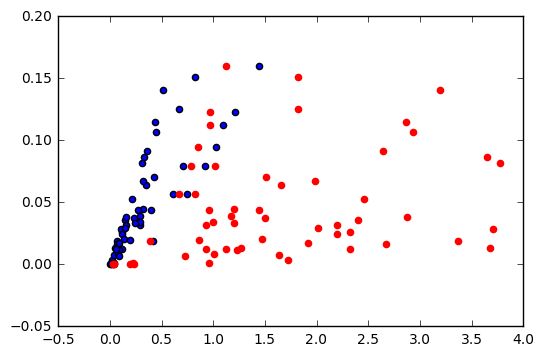

In [505]:

import matplotlib.pyplot as plt

plt.scatter(np.abs(np.log(theta0[0,:,0] / theta0[1,:,0])), mutual_info)

plt.scatter(np.abs(np.log(theta0[0,:,1kk] / theta0[1,:,1])), mutual_info, color='red')

plt.show()